In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np



%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

In [3]:
df_analyse=pd.read_csv('../../data/processed/COVID_small_sync_timeline_table.csv',sep=';') 

In [5]:
df_analyse.sort_values('date',ascending=True).head()

,doubling every day,doubling every two days,doubling every four days,doubling every ten days,Italy,US,Spain,Germany,"Korea, South",date
0,100.0,100.000000,100.000000,100.000000,155.0,104.0,120.0,130.0,104.0,0.0
1,200.0,141.421356,118.920712,107.177346,229.0,174.0,165.0,159.0,204.0,1.0
2,400.0,200.000000,141.421356,114.869835,322.0,222.0,222.0,196.0,433.0,2.0
3,800.0,282.842712,168.179283,123.114441,453.0,337.0,259.0,262.0,602.0,3.0
4,1600.0,400.000000,200.000000,131.950791,655.0,451.0,400.0,482.0,833.0,4.0


In [7]:
country_list=df_analyse.columns[1:]

# Helper Function

In [26]:
def quick_plot(x_in, df_input, y_scale = 'log', slider = False):
    fig =go.Figure()
    
    for each in df_input.columns:
        fig.add_trace(go.Scatter(
                        x=x_in,
                        y = df_input[each],
                        name = each,
                        opacity = 0.8))
    
    fig.update_layout(autosize = True,
                     width = 1024,
                     height = 768,
                     font=dict(
                     family= "PT Sans, monospace",
                     size = 18,
                     color= '#7f7f7f'
                     )
            )
    fig.update_yaxes(type=y_scale),
    fig.update_xaxes(tickangle= -45,
                    nticks=20,
                    tickfont=dict(size=14,color='#7f7f7f')
                    )
    if slider==True:
        fig.update_layout(xaxis_rangeslider_visible=True)
    fig.show()

In [30]:
quick_plot(df_analyse.date,
           df_analyse.iloc[:,4:-1],
           y_scale='log',
           slider=True)

# Fitting a polynomial curve 

In [34]:
df_poly_check=df_analyse.iloc[0:50,4:-1].reset_index()
df_poly_check.head()

,index,Italy,US,Spain,Germany,"Korea, South"
0,0,155.0,104.0,120.0,130.0,104.0
1,1,229.0,174.0,165.0,159.0,204.0
2,2,322.0,222.0,222.0,196.0,433.0
3,3,453.0,337.0,259.0,262.0,602.0
4,4,655.0,451.0,400.0,482.0,833.0


In [36]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [37]:
y=df_poly_check[['Germany','Italy','US','Spain']].unstack().sort_index(axis=0,level=1)

In [40]:
y.head()

Germany  0    130.0
Italy    0    155.0
US       0    104.0
Spain    0    120.0
Germany  1    159.0
dtype: float64

In [50]:
test_points=51
y_train=y[0:-test_points-1]
y_test=y[-test_points:]

In [51]:
X_train=np.arange(len(y_train)).reshape(-1, 1)/4.0 
X_test=np.arange(len(y_train),len(y_train)+test_points).reshape(-1, 1)/4.0

In [52]:
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn;
seaborn.set(rc={'figure.figsize':(16,8)})

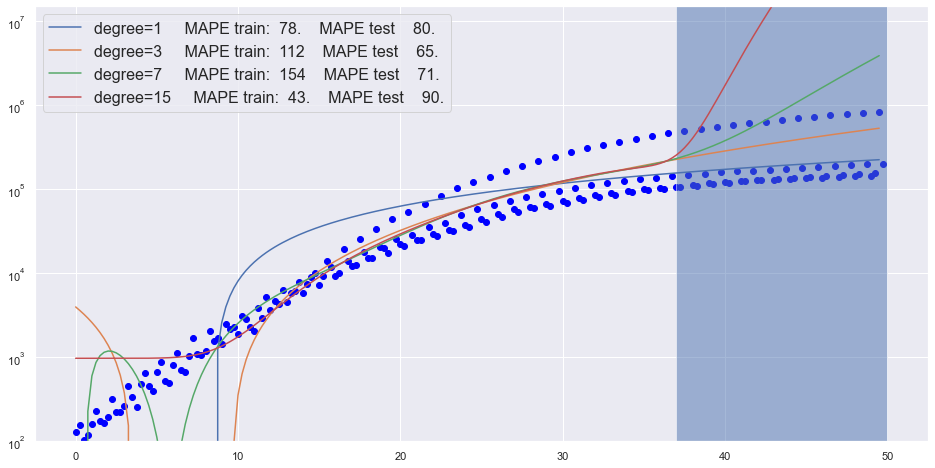

In [67]:
fig, ax1 = plt.subplots(1, 1)

ax1.scatter(np.arange(len(y))/4,y, color='blue')
ax1.axvspan((len(y)-test_points-1)/4, len(y)/4, facecolor='b', alpha=0.5)

for degree in [1,3,7,15]:
    y_hat_insaple=PolynomialRegression(degree).fit(X_train, y_train).predict(X_train)
    y_hat_test = PolynomialRegression(degree).fit(X_train, y_train).predict(X_test)



    X_plot=np.concatenate((X_train, X_test), axis=None)
    y_plot=np.concatenate((y_hat_insaple, y_hat_test), axis=None)

    ax1.plot(X_plot, y_plot, label='degree={0}'.format(degree)+ 
                 '     MAPE train:  ' + str(mean_absolute_percentage_error(y_hat_insaple, y_train))[0:3]
                 +'    MAPE test    ' +str(mean_absolute_percentage_error(y_hat_test, y_test))[0:3]) 

ax1.set_ylim(100, 15000000)
ax1.set_yscale('log')
ax1.legend(loc='best',
           prop={'size': 16});

# Regression Metrics (source Wikkipedia)

## 1. Mean Absolute Error

## 2. Mean Absolute Percentage Error (MAPE)

In [57]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 3. Symetric mean absolute percentage error